### Import

In [3]:
import numpy as np
import os
import sys
import json
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt
import enchant
from tqdm import tqdm
from sklearn.decomposition import PCA

### Corpus Dictionary, Count and Probability Class

In [83]:
class Corpus:
    
    def __init__(self, label, corpus):
        self.label = label
        self.corpus = corpus
        self.dictionary = {}
        self.counts = []
        self.frequencies = []
        self.keywords = []
        self.min_count = 50
        self.max_frequency = 0.001
        
    def build(self):
        
        self.word_count()
        self.get_keywords()
        self.get_counts()
        self.get_frequencies()
        self.sort_by_frequency()

    def word_count(self):
        for text in self.corpus:
            words = text.split(' ')
            for word in words:
                if word in self.dictionary:
                    count = self.dictionary[word]
                    self.dictionary[word] = count + 1
                else:
                    self.dictionary[word] = 1
                    
    def get_keywords(self):
        self.keywords = np.array(list(self.dictionary.keys()))

    def get_counts(self):        
        self.counts = np.array(list(self.dictionary.values()))
        
    def get_frequencies(self):        
        self.frequencies = self.counts / np.sum(self.counts)

    def sort_by_frequency(self):        
        self.indices = np.argsort(self.frequencies)[::-1]
        self.frequencies = self.frequencies[self.indices]
        self.counts = self.counts[self.indices]
        self.keywords = self.keywords[self.indices]   
        
    def restrict(self):
        self.indices = np.where(self.counts > self.min_count)[0]
        self.keywords = self.keywords[self.indices]
        self.frequencies = self.frequencies[self.indices]
        self.counts = self.counts[self.indices]
        
        self.indices = np.where(self.frequencies < self.max_frequency)[0]
        self.keywords = self.keywords[self.indices]
        self.frequencies = self.frequencies[self.indices]
        self.counts = self.counts[self.indices]
        

### Load and unpack

In [84]:
data = pickle.load( open("../../data/articles/pickle/processed.p", "rb"))
records = data['records']
labels = []
abstracts = []
for item in records:
    title,abstract,authors,label = item
    abstracts.append(abstract)
    labels.append(label)
labels = np.array(labels)
abstracts = np.array(abstracts)
classes = np.unique(labels)

### Create a Corpus for each class and an overall corpus

In [85]:
corpi = {}
corpi['overall'] = Corpus('overall',abstracts)
corpi['overall'].build()
corpi['overall'].restrict()
for name in classes:

    indices = np.where(labels == name)[0]
    abstracts_subset = abstracts[indices]
    corpi[name] = Corpus(name,abstracts_subset)
    corpi[name].build()
    corpi[name].restrict()

### Plot the Frequencies curver for all dictionaries 

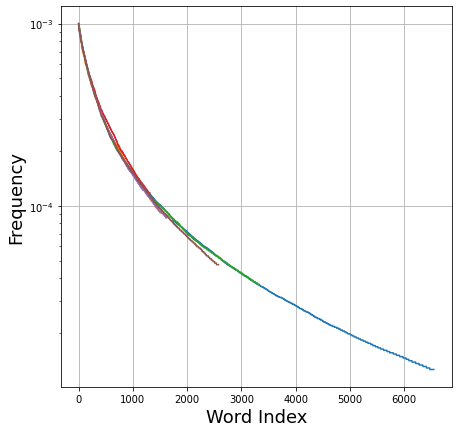

In [86]:
plt.figure(figsize=(7,7));
for item in corpi:

    corpus = corpi[item]
    plt.plot(corpus.frequencies);
    plt.xlabel('Word Index',fontsize=18);
    plt.ylabel('Frequency',fontsize=18);
    plt.yscale("log")
    plt.grid('on');

### Compute apriori probabilities

In [85]:
no_total = len(labels)
no_spam = np.sum(labels)
no_ham = no_total - no_spam
prob_spam = no_spam / no_total
prob_ham = no_ham / no_total

### Compute Word Probabilities

In [86]:
prob_word = frequencies.copy()

### Count Words given Ham

In [127]:
labels = np.array(labels)
ham_indices = np.where(labels == 0)[0]
count_word_ham = np.zeros((prob_word.shape))
for index in tqdm(ham_indices):
    text = corpus[index]
    label = labels[index]
    words = text.split(' ')
    words = np.unique(words)
    for word in words:
        if word in keywords:
            index = np.where(keywords == word)[0][0]
            count_word_ham[index] = count_word_ham[index] + 1

### Count Words given Spam

In [128]:
labels = np.array(labels)
spam_indices = np.where(labels == 1)[0]
count_word_spam = np.zeros((prob_word.shape))
for index in tqdm(spam_indices):
    text = corpus[index]
    label = labels[index]
    words = text.split(' ')
    words = np.unique(words)
    for word in words:
        if word in keywords:
            index = np.where(keywords == word)[0][0]
            count_word_spam[index] = count_word_spam[index] + 1

### Normalize

In [129]:
prob_word_ham = count_word_ham / np.sum(count_word_ham)
prob_word_spam = count_word_spam / np.sum(count_word_spam)

### Collect Probabilities and keyword into model

In [140]:
model = {}
model['prob_spam'] = prob_spam
model['prob_ham'] = prob_ham
model['prob_word'] = prob_word
model['prob_word_ham'] = prob_word_ham
model['prob_word_spam'] = prob_word_spam
model['dictionary'] = keywords

### Predict Helper

In [224]:
def predict(text,model):
    
    #Unpack
    keywords = model['dictionary']
    prob_spam = model['prob_spam']
    prob_ham = model['prob_ham']
    prob_word = model['prob_word']
    prob_word_ham = model['prob_word_ham']
    prob_word_spam = model['prob_word_spam']
    
    #Loop Through Text
    words = text.split(' ')
    prob_ham_word = 1
    prob_spam_word = 1 
    for word in words:
        index = np.where(keywords == word)[0]
        if (len(index) > 0):
            index = index[0]
            prob_ham_word = prob_ham_word * ((prob_word_ham[index] * prob_ham) / prob_word[index])
            prob_spam_word = prob_spam_word * ((prob_word_spam[index] * prob_spam) / prob_word[index])
    prob_ham_word = prob_ham_word / (prob_ham_word + prob_spam_word)
    prob_spam_word = prob_spam_word / (prob_ham_word + prob_spam_word)
    
    #Return
    return prob_spam_word

### Predict

In [229]:
y_pred = []
for index in tqdm(range(len(corpus))):
    text = corpus[index]
    label = labels[index]
    prob = predict(text,model)
    pred = prob > 0.5
    y_pred.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33705/33705 [05:14<00:00, 107.29it/s]


In [220]:
0.0002650074189864993 / 6.815956912460616e-05

3.888044223137987

In [1]:
print(text)
print(y_pred)


NameError: name 'text' is not defined